In [ ]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 33.3 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import json
import pandas as pd
from pycocotools.coco import COCO
import numpy as np
from matplotlib import pyplot as plt
import albumentations as A
from torchvision import models
from torchmetrics.classification import MulticlassJaccardIndex
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


device

In [ ]:
GPU = 'cuda'
path = "gdrive/MyDrive/turtles-data/data/"
fcn_file = "gdrive/MyDrive/fcn.pt"

In [ ]:
with open(f"{path}annotations.json", 'r', encoding='utf8') as file:
    data = json.load(file)

## Pretrained Model

In [ ]:
fcn = models.segmentation.fcn_resnet101(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:13<00:00, 16.2MB/s]


In [ ]:
csv = pd.read_csv(f"{path}metadata_splits.csv")
coco = COCO(f"{path}annotations.json")
fcn.classifier[4] = nn.Conv2d(512, 4, kernel_size=(1, 1))
optimizer = torch.optim.Adam(fcn.parameters()) # default lr=0.001

loading annotations into memory...
Done (t=6.20s)
creating index...
index created!


In [ ]:
# Split based on split_open given by dataset
train_data = csv[csv["split_open"] == "train"]
valid_data = csv[csv["split_open"] == "valid"]
test_data = csv[csv["split_open"] == "test"]

# List of ids
train_ids = train_data["id"].tolist()
valid_ids = valid_data["id"].tolist()
test_ids = test_data["id"].tolist()

# Length of sets
print(len(train_ids))
print(len(valid_ids))
print(len(test_ids))

5303
1118
2308


In [ ]:
class SeaTurtleDataset(Dataset):
  def __init__(self, ids, coco, transform=None):
    self.ids = ids
    self.coco = coco
    self.path = path
    self.transform = transform

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, idx):
    id = self.ids[idx]
    annId = coco.getAnnIds(id)
    anns = coco.loadAnns(annId)
    img = coco.imgs[id]
    image = np.array(Image.open(self.path + img['file_name']))
    if len(anns) != 0:
      mask = coco.annToMask(anns[0])
      for i in range(len(anns)):
        mask += coco.annToMask(anns[i])
    else:
      mask = np.zeros((img['height'], img['width']), dtype=np.uint8)

    if self.transform:
      transformed = self.transform(image=image, mask=mask)
      image = transformed["image"]
      mask = transformed["mask"]

    return image, mask

In [ ]:
trf = A.Compose([
 A.Resize(256, 256),
 A.CenterCrop(224, 224),
 A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
 ToTensorV2()
])

In [ ]:
train_set = SeaTurtleDataset(train_ids, coco, trf)
valid_set = SeaTurtleDataset(valid_ids, coco, trf)
test_set = SeaTurtleDataset(test_ids, coco, trf)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_set, batch_size=4, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=True, drop_last=True)

In [ ]:
if torch.cuda.is_available():
  fcn.to(GPU)
loss_fun = nn.CrossEntropyLoss()

for epoch in range(5):
  # Train
  train_loss = 0.0
  fcn.train() # set to train mode
  for images, masks in train_loader:
    if torch.cuda.is_available():
      images, masks = images.to(GPU), masks.to(GPU).long()
    masks = masks.long()
    if masks.max() > 3:
      # Treat fifth class as background
      masks = torch.where(masks >= 4, torch.tensor(0, device=masks.device), masks)
    optimizer.zero_grad()
    outputs = fcn(images)['out']
    loss = loss_fun(outputs, masks)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  # Viladation
  valid_loss = 0.0
  fcn.eval() # set to eval mode
  for images, masks in valid_loader:
    if torch.cuda.is_available():
      images, masks = images.to(GPU), masks.to(GPU).long()
    else:
      images, masks = images.to('cpu'), masks.to('cpu').long()
    if masks.max() > 3:
      # Treat fifth class as background
      masks = torch.where(masks >= 4, torch.tensor(0, device=masks.device), masks)
    outputs = fcn(images)['out']
    loss = loss_fun(outputs, masks)
    valid_loss = loss.item() * images.size(0)

  print(f'Epoch [{epoch+1}/{5}], Training Loss: {train_loss / len(train_loader):.4f}, Valid Loss: {valid_loss / len(valid_loader):.4f}')

torch.save(fcn.state_dict(), "fcn.pt")
# reference: https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/

Epoch [1/5], Training Loss: 0.2665, Valid Loss: 0.0022

Epoch [2/5], Training Loss: 0.1985, Valid Loss: 0.0040

Epoch [3/5], Training Loss: 0.1793, Valid Loss: 0.0030

Epoch [4/5], Training Loss: 0.1672, Valid Loss: 0.0024

Epoch [5/5], Training Loss: 0.1551, Valid Loss: 0.0027

// The output copied from local file

In [ ]:
trained_fcn = models.segmentation.fcn_resnet101(pretrained=False, aux_loss=True)
trained_fcn.classifier[4] = nn.Conv2d(512, 4, kernel_size=(1, 1))
trained_fcn.load_state_dict(torch.load(fcn_file))
device = torch.device(GPU if torch.cuda.is_available() else "cpu")
trained_fcn.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 168MB/s]
<ipython-input-12-c78395224992>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
trained_fcn.eval()
iou = MulticlassJaccardIndex(num_classes=4, ignore_index=4, average=None).to(device)
with torch.no_grad():
  for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device).long()
    outputs = trained_fcn(images)['out']
    pred = torch.argmax(outputs, dim=1)
    iou.update(pred, masks)
final_iou = iou.compute()
print(final_iou)

tensor([0.9771, 0.5982, 0.1862, 0.2351], device='cuda:0')


In [ ]:
print(f"Background IoU: {final_iou[0]}")
print(f"Carapace IoU: {final_iou[1]}")
print(f"Flipper IoU: {final_iou[2]}")
print(f"Head IoU: {final_iou[3]}")

Background IoU: 0.9771117568016052
Carapace IoU: 0.5981615781784058
Flipper IoU: 0.18624718487262726
Head IoU: 0.23506951332092285


In [ ]:
# Show True Mask and Predicted Mask of random test image
def show_predictions(trained_fcn, test_loader):
  trained_fcn.eval()
  with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
      images, masks = images.to(device), masks.to(device)
      outputs = trained_fcn(images)['out']
      pred = torch.argmax(outputs, dim=1)
      plt.figure(figsize=(10, 10))
      plt.subplot(2, 1, 1)
      plt.imshow(masks[0].to("cpu"))
      plt.title("True Mask")
      plt.subplot(2, 1, 2)
      plt.imshow(pred[0].to("cpu"))
      plt.title("Predicted Mask")
      break

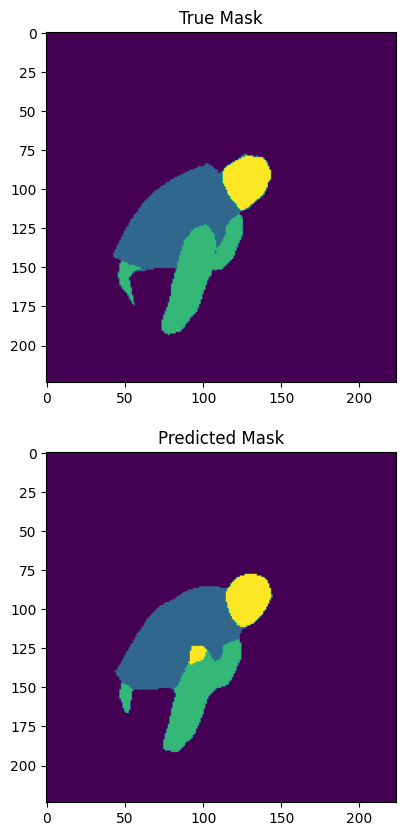

In [ ]:
show_predictions(trained_fcn, test_loader)